# Predict missing labels

## Imports

In [66]:
import scanpy as sc
import pandas as pd
import numpy as np
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
from torch.distributions import Normal
from typing import Optional, Callable, List
from collections import OrderedDict
from scipy import sparse

import scipy
from sklearn.preprocessing import OneHotEncoder

from collections import defaultdict
from tqdm import tqdm
from torch.distributions.kl import kl_divergence as kl
from torch.distributions import Normal, Poisson
import torch.nn.functional as F

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import anndata

import DeepDive


In [8]:
import sys
sys.path.insert(0, "../utils")
from simulation import simulate_scATAC_seq_data_missing
from missing import predict_missing, train_xgb_from_adata
from utils import get_colormap_colors, preprocess, sample_cells_per_donor, tfidf_transform

In [62]:
n_decoders = 1  
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 512
}

In [ ]:
out_res = []
runs = []
effectsize = []
effectsize_lfc = []
n_cells = 5000
n_features = 5000
steps = np.arange(0.05, 1.05, 0.1)

n_runs = 3
for run in range(n_runs):
    for idx, i in enumerate(steps): 
        discrete_covariates = {'cov1': ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10'], 
                               'cov2': ['g1', 'g2']}
        continuous_covariates = {'cov3':[0.0, 1.0]}
        discrete_covriate_keys = list(discrete_covariates.keys())

        simulation_result = simulate_scATAC_seq_data_missing(
            n_cells, 
            n_features, 
            discrete_covariates=discrete_covariates,
            continuous_max_effect_sizes = [4, 4],
            max_effect_sizes=[0.5, i],
            sample_feature_p=[0.1, 0.1],
            continuous_sample_feature_p = [0.2, 0.2],
            dependency=None, 
            continuous_link_to_groups={'cov3':'cov1'},
            continuous_entanglement = 0

        )

        fragment_counts = simulation_result["data"]
        covariate_assignments = simulation_result["covariate_assignments"]
        pivot = simulation_result["pivot"]
        effect_sizes = simulation_result["effect_sizes"]

        adata = anndata.AnnData(fragment_counts)
        adata.X = sparse.csr_matrix(adata.X) 
        adata.obs = covariate_assignments
        adata.obs[discrete_covriate_keys] = adata.obs[discrete_covriate_keys].astype(str)

        true_before = adata.obs['cov2'].copy()
        adata.obs.loc[(adata.obs['cov1'] == 'g1'), 'cov2'] = 'Masked'

        model = DeepDive.DeepDive(adata = adata, 
                                  discrete_covariate_names = discrete_covriate_keys,
                                  unknown_keys = {'cov2':'Masked'},
                                  **model_params
                                 )
        model.train_model(adata, None, **train_params)

        adata_pred = model.predict_missing(adata, covars_to_add = ['cov1', 'cov2'] )

        adata_pred.obs['is_masked'] = list(adata.obs.cov2 == 'Masked')
        adata_pred.obs['true'] = list(true_before)

        adata_pred.obs.groupby('is_masked').value_counts()

        df = adata_pred.obs
        df_sub = df[df.is_masked]
        out_res.append(sum(df_sub.cov2 == df_sub.true) / len(df_sub.cov2))
        runs.append(run)
        effectsize.append(i)
        
        ef = np.log2(effect_sizes['cov2']['g1'] / effect_sizes['cov2']['g2'])
        lfc = np.mean(abs(ef[ef!=0]))
        effectsize_lfc.append(lfc)


cannot use p with more than 2 groups in cov1


Epoch Train [300 / 300]: 100%|██████████| 10/10 [00:00<00:00, 28.99it/s, ETA=01d:00h:01:m05s|01d:00h:01:m05s, kl_loss=6.62, recon_loss=7.03e+3]


Calculating covariate importance.
Predicting cov2 for 497 cells missing that covariate.
cannot use p with more than 2 groups in cov1


Epoch Train [300 / 300]: 100%|██████████| 10/10 [00:00<00:00, 29.38it/s, ETA=01d:00h:01:m03s|01d:00h:01:m03s, kl_loss=6.48, recon_loss=6.99e+3]


Calculating covariate importance.
Predicting cov2 for 518 cells missing that covariate.
cannot use p with more than 2 groups in cov1


Epoch Train [300 / 300]: 100%|██████████| 10/10 [00:00<00:00, 29.32it/s, ETA=01d:00h:01:m05s|01d:00h:01:m05s, kl_loss=6.58, recon_loss=7.05e+3]


Calculating covariate importance.
Predicting cov2 for 495 cells missing that covariate.
cannot use p with more than 2 groups in cov1


Epoch Train [300 / 300]: 100%|██████████| 10/10 [00:00<00:00, 26.68it/s, ETA=01d:00h:01:m07s|01d:00h:01:m07s, kl_loss=6.71, recon_loss=7.03e+3]


Calculating covariate importance.
Predicting cov2 for 487 cells missing that covariate.
cannot use p with more than 2 groups in cov1


Epoch Train [300 / 300]: 100%|██████████| 10/10 [00:00<00:00, 26.40it/s, ETA=01d:00h:01:m09s|01d:00h:01:m09s, kl_loss=6.4, recon_loss=7.02e+3] 


Calculating covariate importance.
Predicting cov2 for 485 cells missing that covariate.
cannot use p with more than 2 groups in cov1


Epoch Train [215 / 300]:  50%|█████     | 5/10 [00:00<00:00, 31.21it/s, ETA=01d:00h:00:m47s|01d:00h:01:m06s, kl_loss=6.48, recon_loss=7.02e+3] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch Train [300 / 300]: 100%|██████████| 10/10 [00:00<00:00, 24.77it/s, ETA=01d:00h:01:m07s|01d:00h:01:m07s, kl_loss=6.5, recon_loss=7.02e+3] 


Calculating covariate importance.
Predicting cov2 for 459 cells missing that covariate.
cannot use p with more than 2 groups in cov1


Epoch Train [300 / 300]: 100%|██████████| 10/10 [00:00<00:00, 24.72it/s, ETA=01d:00h:01:m04s|01d:00h:01:m04s, kl_loss=6.67, recon_loss=6.99e+3]


Calculating covariate importance.
Predicting cov2 for 486 cells missing that covariate.
cannot use p with more than 2 groups in cov1


Epoch Train [12 / 300]:  50%|█████     | 5/10 [00:00<00:00, 42.05it/s, ETA=01d:00h:00:m02s|01d:00h:01:m11s, kl_loss=0, recon_loss=7.17e+3] 

In [ ]:
result = pd.DataFrame([out_res, runs, effectsize, effectsize_lfc], index = ['Accuracy', 'runs', 'effectsize', 'lfc']).T

In [ ]:
mean = result.groupby('effectsize').mean()
sd = result.groupby('effectsize').std()
mean = mean.reset_index()
sd = sd.reset_index()

In [ ]:
colors = get_colormap_colors('RdBu', 10)

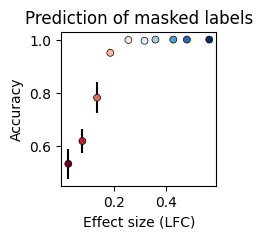

In [71]:
fig, ax = plt.subplots(1,1, figsize = (2,2))

sns.scatterplot(mean, x = 'lfc', y = 'Accuracy', c = [colors[i] for i in mean.index], s = 25, ax = ax, linewidth = 0.5, edgecolor = 'k')
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
plt.errorbar(mean.lfc, mean.Accuracy, yerr=sd.Accuracy,
             fmt="none", color="k")
plt.ylabel('Accuracy')
plt.xlabel('Effect size (LFC)')
plt.title('Prediction of masked labels')
plt.savefig('../figures/F1G.pdf', transparent=True)

## Predict missing on real data

In [41]:
n_decoders = 5
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 1024, 
}

In [42]:
adata = sc.read_h5ad("../data/islet.h5ad")

In [43]:
mapper = {0:'alpha',
1:'beta', 
2:'beta', 
3:'beta', 
4:'alpha', 
5:'beta', 
6:'delta', 
7:'acinar', 
8:'alpha', 
9:'ductal', 
10:'gamma', 
11:'stellate', 
12:'immune', 
13:'endothelial',
}

In [44]:
adata.obs['celltype'] = adata.obs.leiden.map(mapper)

In [45]:
discrete_covriate_keys = ['donor', 'celltype', 'Disease', 'Gender']
continuous_covriate_keys = ['Age', 'HbA1c', 'Purity', 'map_frac', 'BMI']

In [46]:
donors_to_run = adata.obs.donor.unique()

In [47]:
random_state = 42
n_estimators = 500
max_depth = 3
learning_rate = 0.1

In [49]:
to_add = list(set(discrete_covriate_keys + continuous_covriate_keys) - set(['donor']))
counter = 0
for model_path in glob.glob('*.pt', root_dir = '../models/pancreas_downsampled'):
    # Get model
    _, donor_select, _, _ = model_path.split('_')

    # Load anndata
    adata_sub = sc.read_h5ad(f'../data/pancreas_downsampled/downsampled_{donor_select}_Disease_missing.h5ad')

    # Load and setup model
    model = DeepDive.DeepDive(adata = adata_sub, discrete_covariate_names = discrete_covriate_keys, continuous_covariate_names=continuous_covriate_keys, unknown_keys = {'Disease':'Masked'}, **model_params)
    model.load_state_dict(torch.load('../models/pancreas_downsampled/' + model_path))
    model.pin_memory = False
    

    
    # Train classifier on reconstruction with cell type
    adata_train = adata_sub[adata_sub.obs["donor"] != donor_select].copy()
    sc.pp.sample(adata_train, n=10000)
    adata_train.obs['Disease'] = 'T2D'
    adata_train.obs['Disease'] = pd.Categorical(adata_train.obs['Disease'], categories=["T2D", "Non", "Masked"])
    rec_t2d = model.predict(adata_train, batch_size=1024, covars_to_add = to_add)
    adata_train.obs['Disease'] = 'Non'
    adata_train.obs['Disease'] = pd.Categorical(adata_train.obs['Disease'], categories=["T2D", "Non", "Masked"])
    rec_none = model.predict(adata_train, batch_size=1024, covars_to_add = to_add)
    
    # Train XGBoost model
    X = rec_t2d.X - rec_none.X
    celltype_encoder = LabelEncoder()
    ct = celltype_encoder.fit_transform(adata_train.obs['celltype'])
    X = np.concatenate((X, ct[:,np.newaxis]), axis = 1)
    disease_encoder = LabelEncoder()
    y = disease_encoder.fit_transform(adata_train.obs['GT_Disease'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    mod = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        objective="binary:logistic",
        random_state=random_state,
        use_label_encoder=False,
        tree_method="hist"
    )
    mod.fit(X_train, y_train,eval_set=[(X_test, y_test)], eval_metric='logloss', early_stopping_rounds=10, verbose=False)

    adata_test = adata_sub[adata_sub.obs["donor"] == donor_select].copy()
    truth = adata_test.obs['GT_Disease'][0]
    donor = adata_test.obs['donor'][0]
    adata_test.obs['Disease'] = 'T2D'
    adata_test.obs['Disease'] = pd.Categorical(adata_test.obs['Disease'], categories=["T2D", "Non", "Masked"])
    rec_t2d = model.predict(adata_test, batch_size=1024, covars_to_add = to_add)
    adata_test.obs['Disease'] = 'Non'
    adata_test.obs['Disease'] = pd.Categorical(adata_test.obs['Disease'], categories=["T2D", "Non", "Masked"])
    rec_none = model.predict(adata_test, batch_size=1024, covars_to_add = to_add)

    X = rec_t2d.X - rec_none.X
    ct = celltype_encoder.transform(adata_test.obs['celltype'])
    X = np.concatenate((X, ct[:,np.newaxis]), axis = 1)
    
    # Count top 10
    label, count = np.unique(disease_encoder.inverse_transform(np.argmax(mod.predict_proba(X)[mod.predict_proba(X).max(axis=1) >= 0.975,:], axis = 1)),return_counts=True)
    
    # Get fraction
    if (label == truth).sum() > 0:
        true_cells = count[np.argwhere(label == truth)[0]]
    else:
        true_cells = 0
    correct_fraction = true_cells / count.sum()

    # Setup results
    df_tmp = pd.DataFrame({
        'donor': donor,
        'disease': truth,
        'fraction': correct_fraction, 
    }, index = [counter])

    # Concatenate across donors
    if counter == 0:
        acc_res = df_tmp
    else:
        acc_res = pd.concat((acc_res, df_tmp))
    counter += 1


In [57]:
donors_xgb = []
accuracies_xgb = []
disease_xgb = []


for model_path in glob.glob('*.pt', root_dir = '../models/pancreas_downsampled/'):
    # Get model
    _, donor_select, _, _ = model_path.split('_')
    print(donor_select)
    adata_sub = sc.read_h5ad(f'../data/pancreas_downsampled/downsampled_{donor_select}_Disease_missing.h5ad')

    tfidf_transform(adata_sub, log=True)

    adata_train = adata_sub[adata_sub.obs["donor"] != donor_select].copy()
    adata_test = adata_sub[adata_sub.obs["donor"] == donor_select].copy()

    model, y_true, y_pred, encoder, accuracy = train_xgb_from_adata(
        adata_train, adata_test, label_key="GT_Disease"
    )
    donors_xgb.append(donor_select)
    accuracies_xgb.append(accuracy)
    disease_xgb.append(adata_test.obs.GT_Disease[0])



MM109
Accuracy: 0.253
MM98
Accuracy: 0.6955
JYH792
Accuracy: 0.69
MM79
Accuracy: 0.1795
MM60
Accuracy: 0.164
MM97
Accuracy: 0.186
MM88
Accuracy: 0.192
MM51
Accuracy: 0.1385
MM56
Accuracy: 0.435
MM86
Accuracy: 0.7065
MM87
Accuracy: 0.658
MM77
Accuracy: 0.6915
MM81
Accuracy: 0.218
MM95
Accuracy: 0.7395
MM78
Accuracy: 0.537
MM59
Accuracy: 0.7285
MM61
Accuracy: 0.724
MM120
Accuracy: 0.242
MM93
Accuracy: 0.8185
MM80
Accuracy: 0.5925
MM123
Accuracy: 0.7625
MM121
Accuracy: 0.1625
MM57
Accuracy: 0.3315
MM12
Accuracy: 0.254
MM94
Accuracy: 0.21
JYH809
Accuracy: 0.237
MM54
Accuracy: 0.3655
MM89
Accuracy: 0.517
MM110
Accuracy: 0.6555
MM124
Accuracy: 0.7355
MM96
Accuracy: 0.712
MM55
Accuracy: 0.509
MM108
Accuracy: 0.4045
MM122
Accuracy: 0.23


In [58]:
df = pd.DataFrame({'score':{'Baseline':sum([x>0.5 for x in accuracies_xgb]) / len(accuracies_xgb),
                            'DeepDIVE':(acc_res['fraction'] >= 0.5).sum() / len(acc_res)}, 
             })

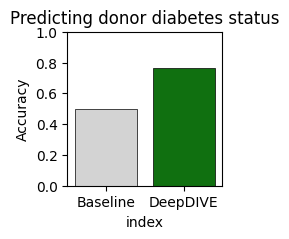

In [61]:
plt.subplots(figsize = (2,2))
sns.barplot(data = df.reset_index(), x = 'index', y = 'score', order = ['Baseline', 'DeepDIVE'], edgecolor = 'k', linewidth = 0.5, palette = ['lightgray', 'green'])
plt.ylim(0,1)

plt.ylabel('Accuracy')
plt.title('Predicting donor diabetes status')
plt.savefig('../figures/S4I.pdf')